# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click !here goes the icon of the corresponding button in the gutter! button.
To debug a cell, press Alt+Shift+Enter, or click !here goes the icon of the corresponding button in the gutter! button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/jupyter-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [7]:
import os
import cv2 # openCV
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd # nice tables in python

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import neural_network
from sklearn.preprocessing import StandardScaler
from sklearn.utils import Bunch
from sklearn.metrics import ConfusionMatrixDisplay


!curl -LJO "https://raw.githubusercontent.com/Digital-Media/cv_data/main/binary_leaves.zip" --silent
import zipfile
with zipfile.ZipFile("binary_leaves.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

number of images: 282


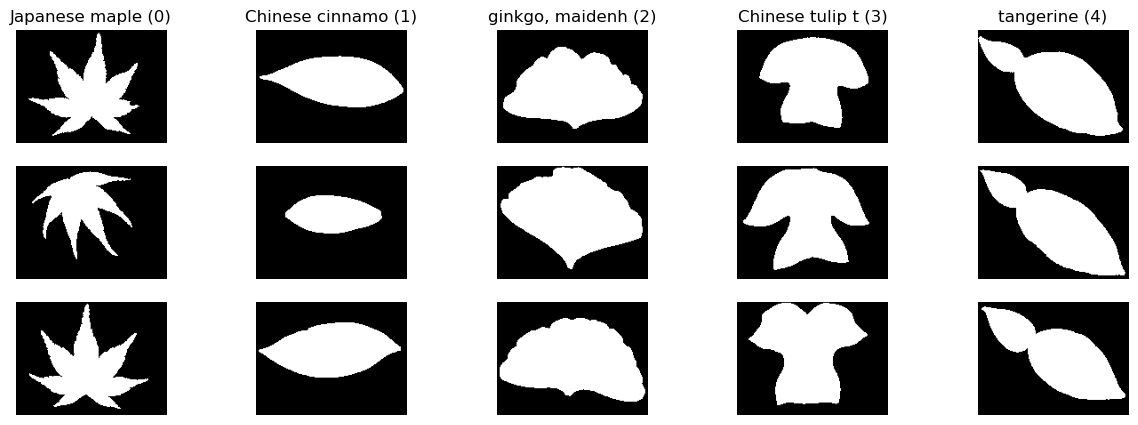

In [8]:
# Load binary leave images and labels

# load label to name mapping from json file
with open('binary_leaves/labels.json') as f:
    label_to_name = dict(json.load(f))
    #label_to_name.pop('1')
    #label_to_name.pop('3')
#print(label_to_name)

mask = []

# load images and labels
images = []
labels = []
file_names = []
for label, name in label_to_name.items():
    if mask.__contains__(name):
        continue
    for file in os.listdir(f'binary_leaves/{label}'):
        
        image = (cv2.imread(f'binary_leaves/{label}/{file}', cv2.IMREAD_GRAYSCALE)>0).astype(np.uint8)
        images.append(image)
        labels.append(label)
        file_names.append(file)

# print simple statistics
print(f'number of images: {len(images)}')

# show an example image for each class
plt.figure(figsize=(15, 5))
# init the random number generator
np.random.seed(1234)
N = 3 # number of images from the same class to show
for label, name in label_to_name.items():
    if mask.__contains__(name):
        continue
    for n in range(N):
        plt.subplot(N, len(label_to_name), n*len(label_to_name) +(int(label)+1))
        # random sample from images with the same label
        idx = np.random.choice(np.where(np.array(labels)==label)[0])
        image = images[idx]
        plt.imshow(image, cmap='gray'), plt.axis('off')
        if n == 0:
            plt.title(f"{name[:15]} ({label})")
plt.show()

In [9]:
import skimage


def compute_properties(img, hu_contour=True, hu_log=True):
    """Compute properties of a binary image.
    Args:
        img (np.array): binary image
        hu_contour (bool): if True, compute the moments of the contour. Otherwise, the entire binary region is used.
        hu_log (bool): if True, compute the log of the Hu moments
    Returns:
        dict: dictionary with properties area, perimeter, circularity, and hu moments (hu_0, hu_1, ... hu_6)
    """
    # get binary regions of binary image and compute their properties (area, BBs, centroid)
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(img)
    assert( len(stats) == 2 ) # foreground (1) and background (0)
    # compute the contour and its perimeter
    contour = cv2.findContours((labels==1).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0][0]
    perimeter = cv2.arcLength(contour, True)
        
    circularity = 4.0*np.pi*stats[1,4]/ (.95*perimeter)**2
    
    #additional parameters
    #edge = np.array(skimage.feature.corner_fast(stats[1,4])).sum()

    simple_props = {'area': stats[1,4], 'perimeter': perimeter, 'circularity': circularity}

    M = cv2.moments(contour if hu_contour else (labels==1).astype(np.uint8) )

    # compute Hu moments
    hu_moments = cv2.HuMoments(M).flatten()
    if hu_log:
        hu_moments = np.sign(hu_moments) * np.log(np.abs(hu_moments)) # log is only defined for positive values, thus use abs
    hu_props = {'hu_'+str(i): hu_moments[i] for i in range(len(hu_moments))}
    
    

    return dict( **simple_props, **hu_props )



# compute properties for one examplary image
np.random.seed(1234) # init the random number generator
num_samples_per_category = 45 # change this to use more samples per category
props = {}
for label, name in label_to_name.items():
    if mask.__contains__(name):
        continue
        # random sample from images with the same label
    idxs = np.random.choice(np.where(np.array(labels)==label)[0], num_samples_per_category, replace=False)
    for idx in idxs:
      image = images[idx]

      cp = compute_properties(image)
      cp.update({'label': int(label)})
      props[f"{name} ({file_names[idx]})"] = cp

# make a pandas table with the hu moments
#pd.options.display.float_format = "{:.3f}".format
df = pd.DataFrame(props)

# show the table
df

,Japanese maple (029.png),Japanese maple (044.png),Japanese maple (008.png),Japanese maple (022.png),Japanese maple (006.png),Japanese maple (050.png),Japanese maple (053.png),Japanese maple (013.png),Japanese maple (018.png),Japanese maple (031.png),...,tangerine (035.png),tangerine (047.png),tangerine (014.png),tangerine (039.png),tangerine (008.png),tangerine (019.png),tangerine (005.png),tangerine (020.png),tangerine (030.png),tangerine (024.png)
area,3501.000000,6434.000000,5810.000000,4695.000000,6064.000000,6560.000000,5226.000000,5233.000000,5391.000000,4852.000000,...,8391.000000,8572.000000,9304.000000,7072.000000,8349.000000,8787.000000,8044.000000,8317.000000,8778.000000,9272.000000
perimeter,482.416301,717.837655,661.310744,567.126978,702.381812,703.352374,642.499562,656.340181,646.239676,649.854900,...,465.244729,462.416301,470.658942,457.730010,454.516807,462.658942,453.445739,472.457932,473.830515,468.073156
circularity,0.209465,0.173857,0.184981,0.203253,0.171149,0.184638,0.176273,0.169144,0.179740,0.159974,...,0.539776,0.558185,0.584817,0.469987,0.562726,0.571586,0.544733,0.518804,0.544393,0.589262
hu_0,-1.572968,-1.596049,-1.575084,-1.587133,-1.587951,-1.575350,-1.532080,-1.567618,-1.583828,-1.581328,...,-1.348907,-1.362851,-1.340645,-1.336448,-1.424807,-1.304945,-1.410206,-1.341505,-1.339690,-1.387910
hu_1,-6.483024,-7.163483,-7.635163,-6.599036,-7.715202,-6.749861,-8.689431,-6.930444,-7.416217,-7.305432,...,-3.253388,-3.275980,-3.194438,-3.202090,-3.544305,-3.073789,-3.505291,-3.227236,-3.202462,-3.358250
hu_2,-8.793858,-8.948998,-8.403246,-8.275504,-7.744915,-8.147895,-7.559778,-7.368623,-10.375221,-7.292175,...,-6.432379,-7.235844,-6.956762,-7.091719,-6.473518,-6.987192,-6.432510,-6.517739,-6.695691,-7.028920
hu_3,-9.425865,-9.695923,-8.690883,-9.683733,-9.534362,-9.277184,-9.218898,-7.916147,-8.753179,-8.087187,...,-7.136924,-7.866409,-7.697145,-7.464417,-7.092607,-7.769556,-7.162915,-7.110182,-7.299519,-7.671700
hu_4,-18.542612,-19.079727,-17.356718,-18.937191,-18.241824,-18.304149,-17.637250,-15.622294,-18.979755,-15.797058,...,-13.921810,-15.417687,-15.024348,-14.742725,-13.875840,-15.151591,-13.960687,-13.924178,-14.297130,-15.022010
hu_5,12.669329,13.284786,12.518497,12.993007,13.409419,12.789681,13.663494,-11.531179,12.511239,-11.865228,...,-8.780197,-9.508654,-9.296310,-9.076530,-8.865945,-9.369406,-8.919447,-8.754321,-8.901675,-9.353458
hu_6,-20.681811,20.097812,-18.014867,-19.095069,19.206374,-18.370654,-19.046091,16.619796,18.471913,17.391642,...,17.755735,-19.469665,-18.823661,18.563995,-17.868318,17.608136,18.482167,-18.707628,-20.083554,-23.791048


In [10]:
def prepare_dataset(dataframe, features):
    
    data = []
    
    for i in range(len(features)):
        data.append(dataframe.values[i])
    
    target = dataframe.values[10]
    
    data = np.array(data).transpose()
    target = np.array(target)
    
    return Bunch(data=data, target=target, feature_names=features)

In [11]:
features = np.array(['area', 'perimeter', 'circularity', 'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6'])
leave_dataset = prepare_dataset(df, features)

X, y = leave_dataset.data, leave_dataset.target
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
#X_train = scaler.fit_transform(x_train)
#X_test = scaler.transform(x_test)

In [12]:
#Model
mlp = neural_network.MLPClassifier(hidden_layer_sizes=(6,5), random_state=42, verbose=True, learning_rate_init=0.01)
mlp.fit(x_train, y_train)

#Predict
y_pred = mlp.predict(x_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
print(accuracy)

report = classification_report(y_test, y_pred, labels=np.unique(y_pred))
print(report)

Iteration 1, loss = 28.23420046
Iteration 2, loss = 28.23420040
Iteration 3, loss = 28.23420034
Iteration 4, loss = 29.43565539
Iteration 5, loss = 29.43565533
Iteration 6, loss = 29.43565526
Iteration 7, loss = 26.09311265
Iteration 8, loss = 28.43444253
Iteration 9, loss = 28.43444247
Iteration 10, loss = 28.43444240
Iteration 11, loss = 28.43444233
Iteration 12, loss = 28.43444227
Iteration 13, loss = 25.68518299
Iteration 14, loss = 22.72174300
Iteration 15, loss = 25.37604615
Iteration 16, loss = 27.07463454
Iteration 17, loss = 27.93995865
Iteration 18, loss = 23.41631176
Iteration 19, loss = 26.41083717
Iteration 20, loss = 27.87857881
Iteration 21, loss = 22.68485766
Iteration 22, loss = 18.95643133
Iteration 23, loss = 21.90853466
Iteration 24, loss = 23.40329722
Iteration 25, loss = 25.15617115
Iteration 26, loss = 25.82769081
Iteration 27, loss = 22.68748280
Iteration 28, loss = 18.74618680
Iteration 29, loss = 22.23287863
Iteration 30, loss = 20.16156817
Iteration 31, loss 

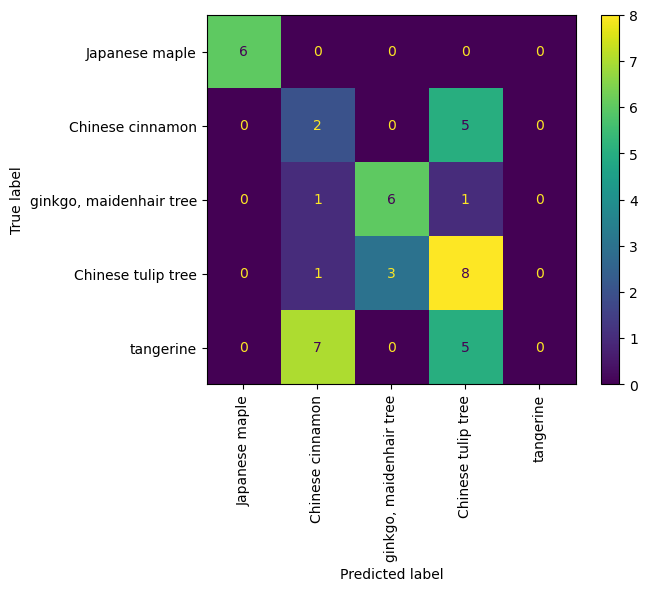

In [13]:


# Let's visualize a confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=list(label_to_name.values())
    )
disp.plot(xticks_rotation='vertical')
plt.show()

In [14]:
#Optimization
#https://datascience.stackexchange.com/questions/36049/how-to-adjust-the-hyperparameters-of-mlp-classifier-to-get-more-perfect-performa

from sklearn.model_selection import GridSearchCV

mlp = neural_network.MLPClassifier(max_iter=1000, hidden_layer_sizes=(6,5), random_state=42, verbose=True, learning_rate_init=0.01)

parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (6,5)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

#clf = GridSearchCV(mlp, parameter_space, n_jobs=-1) #slower, ~3.765ms
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3) #much faster, ~1.87ms
clf.fit(x_train, y_train)



# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

# Best paramete set
print('Best parameters found:\n', clf.best_params_)

#Predict
y_true, y_pred = y_test, clf.predict(x_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
print(accuracy)

report = classification_report(y_true, y_pred, labels=np.unique(y_pred))
print(report)

Iteration 1, loss = 29.45323576
Iteration 2, loss = 29.45183067
Iteration 3, loss = 28.64958041
Iteration 4, loss = 28.63338151
Iteration 5, loss = 28.44716294
Iteration 6, loss = 26.73465694
Iteration 7, loss = 28.10796256
Iteration 8, loss = 27.42201969
Iteration 9, loss = 29.44528922
Iteration 10, loss = 28.27638749
Iteration 11, loss = 21.17204209
Iteration 12, loss = 17.56225362
Iteration 13, loss = 27.28721804
Iteration 14, loss = 28.20474392
Iteration 15, loss = 24.57178668
Iteration 16, loss = 22.71812965
Iteration 17, loss = 21.95354880
Iteration 18, loss = 19.18082449
Iteration 19, loss = 26.86294407
Iteration 20, loss = 18.37073306
Iteration 21, loss = 15.22153714
Iteration 22, loss = 19.04510343
Iteration 23, loss = 17.57394249
Iteration 24, loss = 17.63334573
Iteration 25, loss = 28.41268962
Iteration 26, loss = 24.03553501
Iteration 27, loss = 21.48696214
Iteration 28, loss = 21.29620910
Iteration 29, loss = 10.65429943
Iteration 30, loss = 10.37884724
Iteration 31, loss 

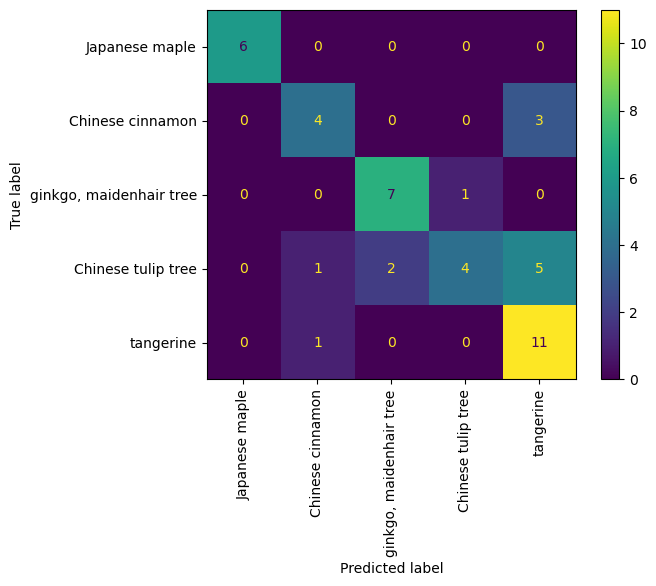

In [15]:
# Let's visualize a confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=list(label_to_name.values())
    )
disp.plot(xticks_rotation='vertical')
plt.show()